# Lecture 16

- Uniform Blur and Gaussian Blur
- Edge detection


Optional reading material:

https://datacarpentry.org/image-processing/06-blurring/

http://jhlabs.com/ip/blurring.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Blurring

Basic noise removal assumes that noise takes the form of pixels that are outliers in their immediate neighborhood. We can remove the noise by “smoothing out” or blurring an image slightly.

### Uniform Blur

A __uniform blur__ does so by setting the color of each pixel in the blurred image to be the average of the pixels in its neighborhood in the original image. The neighborhood takes the form of a `k*k` square around the pixel (where k is odd so that the square has a middle). Taking the uniform mean over this square is quite easy if we use numpy arrays. For example, suppose that the image im is an n×m numpy array of real numbers. Then we can ask for the `k*k` sub-array around pixel `i, j` using the command `im[(i-(k-1)//2):(i+(k-1)//2)+1),(j-(k-1)//2):(j+(k-1)//2)+1)]`. Remember that when we ask for a range `a:b` in an array, the a is included in the output, and the b is not.

Also, when we use numpy arrays, we can multiply two arrays elementwise. This gives a new array which has elements that are the product of elements at corresponding indices in the original arrays. If we wish to find the mean of the elements in a `k*k` array, then we should multiply each element by `1/k^2` (with `k^2` being the number of elements). 


For example,

In [2]:
a=np.array([[1,2],[3,4]])
b=np.array([[1.0/4.0,1.0/4.0],
            [1.0/4.0,1.0/4.0]])
print("a", a)
print("b", b)
print(a*b)

a [[1 2]
 [3 4]]
b [[0.25 0.25]
 [0.25 0.25]]
[[0.25 0.5 ]
 [0.75 1.  ]]


To obtain the mean we then need to sum over all these products.

In [3]:
np.sum(a * b)

2.5

- define a local "patch" M for pixel values in the neighborhood of a target pixel
- define a filter K
- ``np.sum(M*K)``

These are all the basic tools we need to write out denoising function. We can let k, the size of the filter, be a user defined parameter. You can think of this as the coarseness of the sandpaper that we use to smooth our image. The larger k is, the more blurring we get. Then, we create the filter. In the uniform case, this is a square `k*k`  array where every value is `1/k^2`. For example, when k = 5, our filter is

In [4]:
np.array([[(1.0/5)**2]*5]*5)

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

In [5]:
# alternaltively
np.ones((5,5))*(1.0/5**2)

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

We use the filter to recalculate the value of every pixel in the image (except for those too close to the edge to fit the filter around: we will leave those unchanged) to store in the new, blurred image. 

One important thing: when we find the new value for a pixel, we use the mean over the colors of its neighborhood pixels in the original image, even if some of its neighbors already have new values for the blurred image. Therefore, you should store the new values in a new blurred image variable; without making changes in the original image!

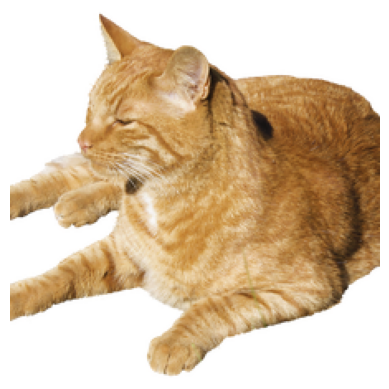

In [3]:
import matplotlib.image as mpimg
img=mpimg.imread('cat.png') 
# img = img + np.random.uniform(-0.2,0.2,img.shape) # add some noise
plt.imshow(img)
plt.axis('off') # remove the axis
plt.show()

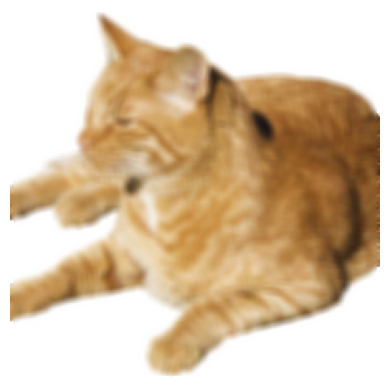

In [4]:
filter = np.ones((5,5))*(1.0/5**2)
blurred_cat = img.copy()
h,w,_ = img.shape
# why 2 and h-2 here?
for i in range(2,h-2):
    for j in range(2, w-2):
      for c in range(3):
        blurred_cat[i,j,c] = np.sum(img[i-2:i+3, j-2:j+3,c] * filter)
plt.imshow(blurred_cat)
plt.axis('off') 
plt.show()

### Gaussian Blur

The idea behind a Gaussian blur is very similar to the uniform blur. The difference is that the weighting of the neighborhood pixels in the calculation of the mean is more sophisticated, and favors pixels that are closer to the current pixel. It achieves this by creating a filter that is weighted proportionally to a 2D Gaussian function (a Bell curve), with its maximum in the middle of the $k \times k$ filter. The 2D Gaussian is given by

$$G(x,y) = \frac{1}{2\pi \sigma^2}\exp\left({-\frac{x^2+y^2}{2\sigma^2}}\right)$$

We wish to center this around the center of the square, which we achieve by giving each element `filter[i,j]` of the filter a value
$$
filter[i,j] = \frac{1}{2\pi \sigma^2}\exp\left({-\frac{(i-(k-1)/2)^2+(j-(k-1)/2)^2}{2\sigma^2}}\right)
$$

The Gaussian distribution function is normalized, meaning that the total volume underneath it adds up to 1. However, we are only using a part of it that fits into the square, not the whole (infinite) function. This means that we need to renormalize the values in our filter. If their sum is less than 1, we would be making the pixels darker on average, which is undesirable. This is easy to do, by dividing the filter by its total sum at the end. Once we have created the filter, our denoising function works exactly the same way as it did with the uniform filter. Note that it has one more parameter: $\sigma$. 
For example, when `k = 5`, and $\sigma = 1$, our filter is

In [5]:
sigma = 1
k = 5
filter=np.array([[0]*k]*k,dtype='float')
for x in range(k):
    for y in range(k):
        filter[x,y]=np.exp(-((x-(k-1)*0.5)**2+(y-(k-1)*0.5)**2)/(2.0*sigma**2))
filter_sum=np.sum(filter)
filter=filter/filter_sum

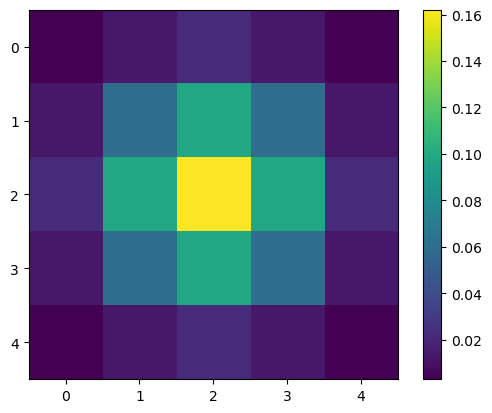

In [6]:
plt.imshow(filter)
plt.colorbar()
plt.show()

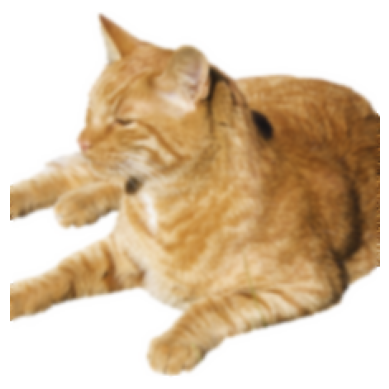

In [7]:
sigma = 1
k = 5
filter=np.array([[0]*k]*k,dtype='float')
for x in range(k):
    for y in range(k):
        filter[x,y]=np.exp(-((x-(k-1)*0.5)**2+(y-(k-1)*0.5)**2)/(2.0*sigma**2))
filter_sum=np.sum(filter)
filter=filter/filter_sum


blurred_cat = img.copy()
h,w,_ = img.shape
# why 2 and h-2 here?
for i in range(2,h-2):
    for j in range(2, w-2):
      for c in range(3):
        blurred_cat[i,j,c] = np.sum(img[i-2:i+3, j-2:j+3,c] * filter)
plt.imshow(blurred_cat)
plt.axis('off') 
plt.show()

By the way, this way of running the filter over our image: placing the filter on top of each pixel, and taking the sum of products of the overlaying elements, is mathematically called a __convolution__. 

You may have seen this before in other classes, but if not, don’t worry. We simply write this as a double loop over all pixels (except for the edge). 

If you are interested in reading more about different types of blurring, there is a nice tutorial [here](http://jhlabs.com/ip/blurring.html). This is written for Java programmers, but the explanations are very nice.

顺便说一句，这种在我们的图像上运行过滤器的方法：将过滤器放在每个像素的顶部，并取叠加元素的乘积之和，在数学上称为 __convolution__。

您可能以前在其他课程中见过这种情况，但如果没有，请不要担心。 我们简单地将其写为对所有像素（边缘除外）的双循环。

如果您有兴趣阅读更多有关不同类型模糊的信息，[此处](http://jhlabs.com/ip/blurring.html) 有一个很好的教程。 这是为 Java 程序员编写的，但解释非常好。


# Edge Detection

Detecting edges in image can be useful for image recognition, classification, retouching, etc.. Now that you have already written the denoising functions from the previous section, it will not be hard to write an edge detection function that uses the Sobel filter. 

When we detect edges, we are not interested in finding a kind of average of a set of pixels; we are interested in the difference. 

For example, a pixel is on a vertical edge when pixels to its left have a different color from pixels on its right. We can measure this difference in much the same way as we did before, by multiplying a pixel’s neighborhood with a filter, and summing over the products. 
As a tiny example, if I want to measure the difference $b-a$ between two elements of a small array [a,b], I multiply elementwise by the array [-1,1], and sum the result. To measure a vertical edge on a pixel, we look at the difference between a vertical strip of pixels to its left and to its right, weighting the immediate neighbors more heavily. 

The Sobel vertical and horizontal filters look, respectively, like,

In [8]:
vertical_filter=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
horizontal_filter=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
print(vertical_filter)

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


In [9]:
print(horizontal_filter)

[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


For each pixel `i,j`, multiplying the `3*3` subarray around it with the (horizontal or vertical) Sobel
filter yields a score (`S_H` or `S_V`) between -4 and 4. 

We can rescale this score to always be between 0
and 1 by taking $$\frac{S_H+4}{8} $$ or $$\frac{S_v+4}{8}.$$ 

Now, __gray__ (.5) indicates __no edge__, __black__ indicates a __negative edge__, and __white__ indicates a __positive edge__. This makes sense if we want to visualize the edges that we found in a grayscale image. 

When we ask for vertical or horizontal edge detection, we will see the difference between negative and postive edges (the color going from high to low or low to high, respectively). For example, the following image gives us the following output for vertical and horizontal edge detection, respectively. Notice the difference between positive and negative detected edges.

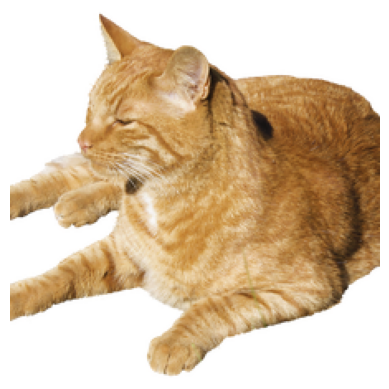

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('cat.png') 
plt.imshow(img)

plt.axis('off')
plt.show()

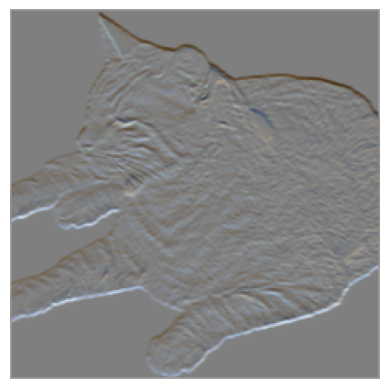

In [11]:
edge_cat_h = img.copy()
filter = horizontal_filter
h,w,_ = img.shape
for i in range(1,h-1):
    for j in range(1, w-1):
      for c in range(3):
        edge_cat_h[i,j,c] = np.sum(img[i-1:i+2, j-1:j+2,c] * filter)

edge_cat_h_n = (edge_cat_h + 4)/8
plt.imshow(edge_cat_h_n)
plt.axis('off') 
plt.show()

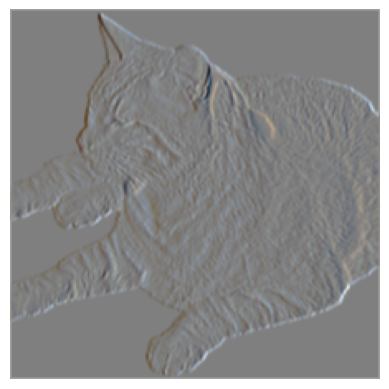

In [12]:
edge_cat_v = img.copy()
filter = vertical_filter
h,w,_ = img.shape
for i in range(1,h-1):
    for j in range(1, w-1):
      for c in range(3):
        edge_cat_v[i,j,c] = np.sum(img[i-1:i+2, j-1:j+2,c] * filter)

edge_cat_v_n = (edge_cat_v + 4)/8
plt.imshow(edge_cat_v_n)
plt.axis('off') 
plt.show()

We may also ask for edge detection in general directions. We do this by combining the horizontal and vertical scores as Euclidean distances: 
$$S = \sqrt{S_V^2+S_H^2}$$
Now, there is not more direction of edges, only strength. We can normalize this score using
$$S = \frac{\sqrt{S_V^2+S_H^2}}{4}$$
so that black indicates no edge, and white indicates a strongest edge.
This should look like this:

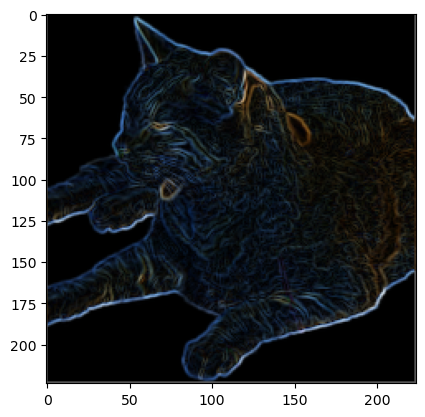

In [19]:
edge_cat = np.sqrt(edge_cat_v**2 + edge_cat_h**2)/4
plt.imshow(edge_cat)
#plt.axis('off') 
plt.show()